In [1]:
# automatically reloads the libary upon changes, only needed if you change the library
%load_ext autoreload
%autoreload 2

In [2]:
# Import the "predator and prey" library, written by Lu
import pnp

# Import relevant plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Check the already included "Models"
pnp.models

[pnp.SimpleModel, pnp.LimitedGrowth, pnp.Grass, pnp.NicholsonBailey]

In [4]:
# A model is an already prepared simulation with starting populations, constants and functions set

# Construct an object from the SimpleModel Class
model = pnp.SimpleModel()

# the model's starting populations
print('population', model.population)
# the model's constants
print('constants', model.constants)
# the model's functions (these are already compiled, so printing them won't give you much insight)
print('functions', model.functions)

population {'rabbit': 1, 'wolf': 1}
constants {'rabbit-r': 1, 'hunt': 1, 'rabbit-value': 1, 'wolf-hunger': 1}
functions {'rabbit': <function SimpleModel.set_functions.<locals>.<lambda> at 0x04DC49B8>, 'wolf': <function SimpleModel.set_functions.<locals>.<lambda> at 0x065417C0>}


In [5]:
# Let's run a simulation!

seperate_df, combined_df = model.run_simulation(100, 0.1) # This notation means we are running 100 steps of step_size 0.1

100%|██████████| 100/100 [00:00<?, ?it/s]


In [6]:
# The simulation above returned two "DataFrames", which are basically fancy spreadsheets from the library "pandas"

# Let's look at the output

# The "seperate DataFrame" keeps the different animal populations in different columns
print('Seperate DataFrame')
print(seperate_df)
print('----------------')
# The "combined DataFrame has a row for each animal population in each step and is therefore not very legibile"
print('Combined DataFrame')
print(combined_df)

Seperate DataFrame
     time  rabbit  wolf
0     0.0     1.0   1.0
1     0.1     1.0   1.0
2     0.2     1.0   1.0
3     0.3     1.0   1.0
4     0.4     1.0   1.0
..    ...     ...   ...
96    9.6     1.0   1.0
97    9.7     1.0   1.0
98    9.8     1.0   1.0
99    9.9     1.0   1.0
100  10.0     1.0   1.0

[101 rows x 3 columns]
----------------
Combined DataFrame
     time animal_type  animal_number
0     0.0      rabbit            1.0
1     0.0        wolf            1.0
2     0.1      rabbit            1.0
3     0.1        wolf            1.0
4     0.2      rabbit            1.0
..    ...         ...            ...
197   9.8        wolf            1.0
198   9.9      rabbit            1.0
199   9.9        wolf            1.0
200  10.0      rabbit            1.0
201  10.0        wolf            1.0

[202 rows x 3 columns]


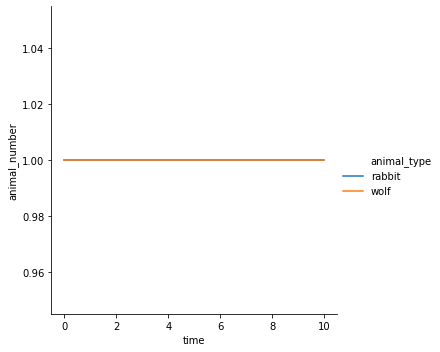

In [7]:
# The strength of the combined DataFrame will become apparent in plotting

# As is visible, the combined_df (which can be seen in the "data" argument) is very important for plotting
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

100%|██████████| 100/100 [00:00<?, ?it/s]


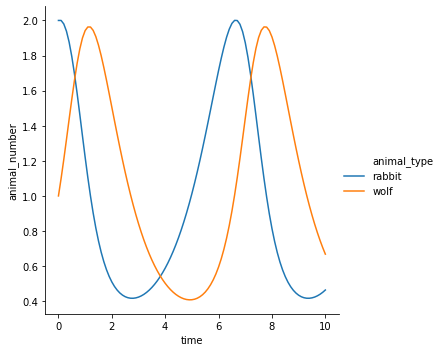

In [8]:
# The plot in the step above does not look right, both rabbit and wolf stay constant
# This is because by default all prebuilt models are IN EQUILIBRIUM, to get any meaningful results you have to change some of the variables

# Let's change some variables

# Starting with double as many rabbits as before
model.population['rabbit'] = 2

seperate_df, combined_df = model.run_simulation(100, 0.1) # Running the simulation again
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

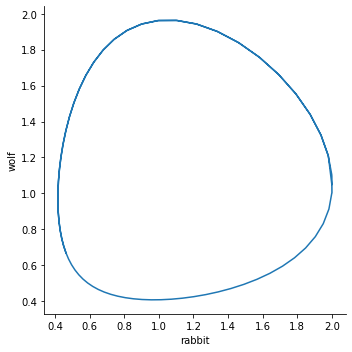

In [9]:
# Another thing one can do is plotting the datapoints in a phase space of "rabbit" and "wolf"

# Note that we use the "seperate" DataFrame for this
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=seperate_df)

100%|██████████| 500/500 [00:00<?, ?it/s]


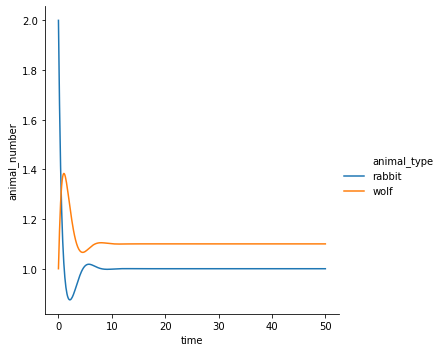

In [10]:
# Other things you may change are


# Constants
# Changing the rabbit reproduction rate from 1 to 1.1
model.constants['rabbit-r'] = 1.1

# Functions (quite complicated)
# Changing it so that a too high rabbit population decreases the population again
model.functions['rabbit'] = lambda population, constants: population['rabbit'] * (constants['rabbit-r'] - constants['hunt'] * population['wolf'] * population['rabbit'])

seperate_df, combined_df = model.run_simulation(500, 0.1) # Running the simulation again
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

100%|██████████| 100/100 [00:00<?, ?it/s]


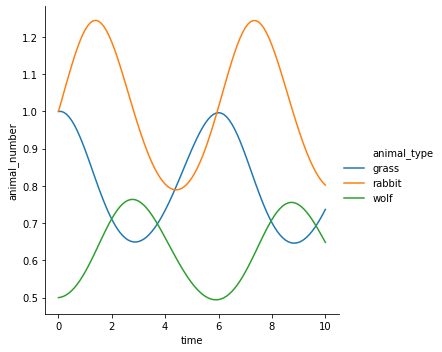

In [11]:
# Creating your own model by setting up the starting conditions

class Grass(pnp.Model): # We are using the pnp.Model class as our base
    
    def set_population(self):
        return {
        'grass': 1,
        'rabbit': 1,
        'wolf': 1
        }

    def set_constants(self): # constants
        return {
            'grass-r': 1,
            'rabbit-hunt': 1,
            'grass-value': 1,
            'rabbit-hunger': 0.5,
            'wolf-hunt': 0.5,
            'rabbit-value': 1,
            'wolf-hunger': 1
        }

    def set_functions(self): # functions
        return {
            'grass': lambda population, constants: population['grass'] * (constants['grass-r'] - constants['rabbit-hunt'] * population['rabbit']),
            'rabbit': lambda population, constants: population['rabbit'] * (constants['grass-value'] * population['grass'] - constants['rabbit-hunger'] - constants['wolf-hunt'] * population['wolf']),
            'wolf': lambda population, constants: population['wolf'] * (constants['rabbit-value'] * population['rabbit'] - constants['wolf-hunger'])
        }

# This model may now be used like any other model
model = Grass()

model.population['wolf'] = 0.5

seperate_df, combined_df = model.run_simulation(100, 0.1) # Running the simulation
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

100%|██████████| 100000/100000 [00:00<00:00, 386628.46it/s]


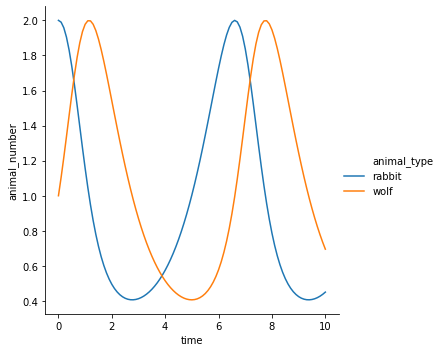

In [12]:
# As you may have noticed/suspected, this library is not perfect at simulating derivatives, it actually overshoots inversly proportional to the stepsize
# But decreasing the stepsize means having to simulate a lot more steps to get the same result
# This can create unwieldy amounts of data, which is why the optional parameter of "compression" exists

model = pnp.SimpleModel()
model.population['rabbit'] = 2 # removing the equilibrium

# Here we add "compression=x"
# This means only saving every xth step!
seperate_df, combined_df = model.run_simulation(10**5, 10**-4, compression=10**3) # Running the simulation

# A good rule of thumb is the following ratio
# stepamount a: 1
# stepsize s: 10/s
# compression c: a/100

# You may notice that running the simulation takes a bit more time

# But due to our compression, plotting is still fast!
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

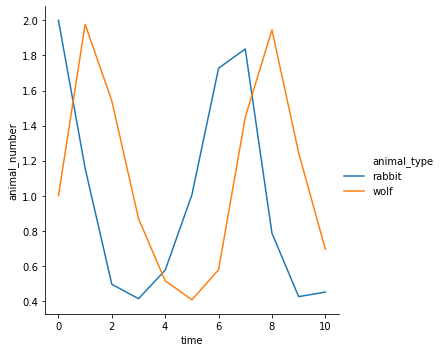

In [13]:
# If you have already generated a dataset and wish to compress it, the pnp package also has the "prune" function

# This reduces the amount of steps by the factor of 10
combined_df = pnp.prune(combined_df, 10)

# Side effects include faster plotting and edgier plots
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

# Only consider using "prune" if the compression built into the simulation somehow does not adress your problem

In [14]:
# Generally, the longer your simulation goes on for, the less accurate it becomes
# This in turn means that you have to reduce the step_size even further!

model = pnp.SimpleModel()
model.population['rabbit'] = 2

# Relatively high accuracy of the simulation, might take a few seconds
readable_df, combined_df = model.run_simulation(5*10**6, 10**-5, compression=10**4)

100%|██████████| 5000000/5000000 [00:10<00:00, 491303.29it/s]


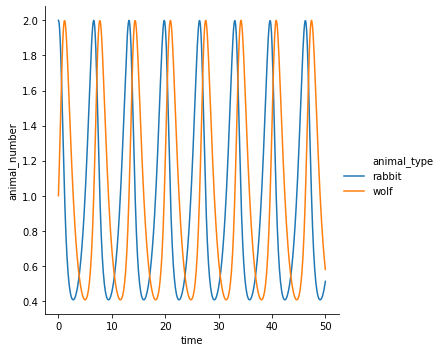

In [15]:
# Plotting reveals that the amplitude (according to the theoretical model) does not change
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

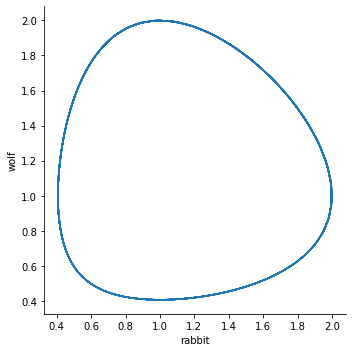

In [16]:
# Plotting rabbits vs wolves reveals a very stable cycle
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=readable_df)

100%|██████████| 5000/5000 [00:00<00:00, 633676.39it/s]


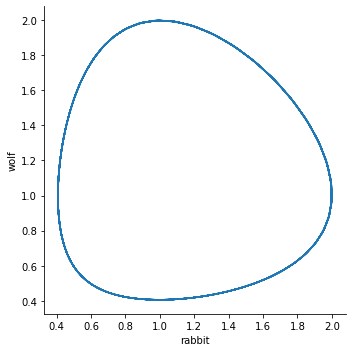

In [17]:
# A less accurate (but faster) simulation to show the danger of the inaccuracies

model = pnp.SimpleModel()
model.population['rabbit'] = 2

readable_df, combined_df = model.run_simulation(5*10**3, 10**-2, compression=10**1)
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=readable_df)

# Attempt to keep the stepsize at 10**-4 or lower! Especially if you are running a longer simulation